## Prioritizer Model

Trained model for classification and prioritization for ALFABURST events based on the labelled feature set from  featureBuilder.ipynb.

### Classifier model

Probabalistic classifier using random forests.

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Preamble

Read in the dataframe and prepare the features for use in scikit-learn.

In [2]:
pd.__version__

u'0.19.2'

In [3]:
df = pd.read_pickle('featureDataframe.pkl')

In [4]:
df.describe()

,Beam,Buffer,MJDstart,bestDM,bestSNR,BinFactor,Events,DMmax,DMmin,DMmean,...,pixelMean_15_0,pixelMax_15_1,pixelMin_15_1,pixelMean_15_1,pixelMax_15_2,pixelMin_15_2,pixelMean_15_2,pixelMax_15_3,pixelMin_15_3,pixelMean_15_3
count,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,7.328200e+04,73282.000000,73282.000000,73282.000000,...,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04
mean,3.556617,211.437952,57392.275750,994.132829,12.890546,14.171406,5.290837e+03,1843.879770,355.848537,1106.626399,...,3.036053e+38,3.663497e+38,3.663497e+38,3.663497e+38,3.122199e+38,3.122199e+38,3.122199e+38,2.912765e+38,2.912765e+38,2.912765e+38
std,2.433997,272.753575,186.092812,2270.499049,79.265038,20.233713,3.448143e+04,3329.930528,1195.291547,2135.608269,...,1.204643e+39,1.308466e+39,1.308466e+39,1.308466e+39,1.157410e+39,1.157410e+39,1.157410e+39,1.196846e+39,1.196846e+39,1.196846e+39
min,0.000000,1.000000,57197.378446,0.000000,6.001704,1.000000,1.000000e+00,3.000000,0.000000,3.000000,...,-8.851245e+04,-1.229460e+05,-1.229460e+05,-1.229460e+05,-1.541351e+05,-1.541351e+05,-1.541351e+05,-1.649856e+05,-1.649856e+05,-1.649856e+05
25%,1.000000,25.000000,57275.173537,7.000000,10.510364,2.000000,4.000000e+00,10.000000,5.000000,7.500000,...,-1.281110e+01,1.217415e+01,1.217415e+01,1.217415e+01,1.911395e+01,1.911395e+01,1.911395e+01,2.122114e+01,2.122114e+01,2.122114e+01
50%,4.000000,111.000000,57328.330289,13.000000,11.301913,4.000000,3.400000e+01,27.000000,7.000000,16.500000,...,3.136781e+00,2.029442e+01,2.029442e+01,2.029442e+01,3.726743e+01,3.726743e+01,3.726743e+01,4.588743e+01,4.588743e+01,4.588743e+01
75%,6.000000,295.000000,57372.219326,273.000000,12.641252,16.000000,4.890000e+02,2024.000000,16.000000,947.812319,...,3.046355e+01,3.833758e+01,3.833758e+01,3.833758e+01,6.726700e+01,6.726700e+01,6.726700e+01,8.036246e+01,8.036246e+01,8.036246e+01
max,6.000000,2001.000000,57893.840891,10039.000000,20954.304688,64.000000,2.135578e+06,57287.182376,10035.000000,10035.500000,...,1.956399e+40,2.133469e+40,2.133469e+40,2.133469e+40,2.055277e+40,2.055277e+40,2.055277e+40,2.146130e+40,2.146130e+40,2.146130e+40


In [5]:
df.shape

(73282, 406)

#### Re-label Mis-labelled Type 8 Events

In [6]:
reLabel = [('Beam4_fb_D20150821T195709.fil', 202),
           ('Beam0_fb_D20150906T194609.fil', 275),
           ('Beam4_fb_D20150909T235709.fil', 467),
           ('Beam6_fb_D20150925T221909.fil', 3),
           ('Beam1_fb_D20151215T221703.fil', 377),
           ('Beam1_fb_D20151215T221703.fil', 595),
           ('Beam1_fb_D20151216T231103.fil', 50),
           ('Beam1_fb_D20151217T050412.fil', 196),
           ('Beam1_fb_D20151217T050412.fil', 197),
           ('Beam1_fb_D20151217T050412.fil', 202),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170310T020409.fil', 8),
           ('Beam0_fb_D20170310T020409.fil', 9),
           ('Beam0_fb_D20170310T020409.fil', 11),
           ('Beam0_fb_D20170310T020409.fil', 14),
           ('Beam0_fb_D20170310T020409.fil', 15),
           ('Beam0_fb_D20170310T020409.fil', 16),
           ('Beam0_fb_D20170310T020409.fil', 17),
           ('Beam0_fb_D20170310T020409.fil', 19),
           ('Beam0_fb_D20170310T020409.fil', 21),
           ('Beam0_fb_D20170310T020409.fil', 25),
           ('Beam1_fb_D20170310T020409.fil', 4),
           ('Beam4_fb_D20170310T020409.fil', 7),
           ('Beam5_fb_D20170310T020409.fil', 1),
           ('Beam5_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170312T182504.fil', 2),
           ('Beam2_fb_D20170325T011509.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170311T184903.fil', 1),
           ('Beam5_fb_D20170312T182504.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 3),
           ('Beam4_fb_D20170312T182504.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 2),
           ('Beam4_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 1),
           ('Beam0_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 5),
           ('Beam0_fb_D20170310T020409.fil', 7),
           ('Beam0_fb_D20170310T020409.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 12),
           ('Beam0_fb_D20170310T020409.fil', 13),
           ('Beam0_fb_D20170310T020409.fil', 18),
           ('Beam0_fb_D20170310T020409.fil', 20),
           ('Beam0_fb_D20170310T020409.fil', 22),
           ('Beam0_fb_D20170310T020409.fil', 23),
           ('Beam0_fb_D20170310T020409.fil', 24),
           ('Beam1_fb_D20170310T020409.fil', 1),
           ('Beam4_fb_D20170310T020409.fil', 3),
           ('Beam4_fb_D20170310T020409.fil', 5),
           ('Beam4_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170311T184903.fil', 1)]

In [7]:
# Relabel mis-labelled events to overflow (label 8)
for fil,buf in reLabel:
    #print fil, buf
    df.loc[(df['filterbank']==fil) & (df['Buffer']==buf), 'Label'] = 8

#### Compute MJD Features

We don't care about the absolute MJDs, but the relative offset within the dataset.

In [8]:
df['relMJDmax'] = df['MJDmax'] - df['MJDmin']
df['relMJDmean'] = df['MJDmean'] - df['MJDmin']
df['relMJDmedian'] = df['MJDmedian'] - df['MJDmin']

**Filter for only labelled data (i.e. Label > -1) and Drop Type 8 Events**

In [9]:
labelledDf = df[df['Label'] > -1]
labelledDf = labelledDf[labelledDf['Label'] != 8]

**Relabel 0 to 9**

We are interested in both 9 and 0 labels and both appear similar.

In [10]:
labelledDf.loc[labelledDf['Label'] == 0, 'Label'] = 9

In [11]:
for col in labelledDf:
    if labelledDf[col].dtype == object: print col, labelledDf[col].min(), labelledDf[col].max()
    else: print col, labelledDf[col].min(), labelledDf[col].max(), labelledDf[col].std()

datfile Beam0_dm_D20150624T020452.dat Beam6_dm_D20170324T215304.dat
Beam 0 6 2.64289416941
TSID D20150624T020452 D20170325T092403
Buffer 1 1997 234.099730177
MJDstart 57197.3848466 57837.3807827 158.637469447
bestDM 51.0 10039.0 2925.42377249
bestSNR 10.0002756119 181.342330933 7.78511888853
BinFactor 1 64 23.3707904092
Events 1 1800508 63404.711047
DMmax 54.0 10039.0 3741.79111564
DMmin 0.0 10035.0 1854.50379848
DMmean 25.1612903226 10035.5 2705.60863642
DMmedian 9.0 10035.5 2819.01443151
DMstd 0.707106781187 4672.49363237 881.751739387
SNRmean 7.07141349051 19.9987541906 1.31552412109
SNRmedian 6.77030944824 15.0827293396 0.96828782134
SNRstd 0.000775502012695 14.4079302489 1.31336401293
MJDmax 57197.3848944 57837.3808056 158.637465108
MJDmin 57197.3848934 57837.3808055 158.637468173
MJDstd 0.0 4.11672955923e-05 8.34844478405e-06
MJDmean 57197.384894 57837.3808055 158.637466696
MJDmedian 57197.384894 57837.3808055 158.637466697
Label 1 9 2.14351963379
predictLabel -1 -1 0.0
filterban

**Apply Direct Data Cleaning Filters**

In [12]:
# Check that data during March 2017 has been removed
for row in labelledDf.iterrows():
    idx, data = row
    if (data['globtsStatsMean'] < -3e3) or (data['globtsStatsMin'] < -3e3): print idx
        
# Check that all events which overflow have been dropped
for row in labelledDf.iterrows():
    idx, data = row
    if data['ofCount'] > 0.: print idx

In [13]:
print labelledDf.shape

(13419, 409)


**Select out the labels**

In [14]:
labels = labelledDf['Label'].values

**Drop the meta-information columns**

In [15]:
labelledDf.columns

Index([u'datfile', u'Beam', u'TSID', u'Buffer', u'MJDstart', u'bestDM',
       u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       ...
       u'pixelMean_15_1', u'pixelMax_15_2', u'pixelMin_15_2',
       u'pixelMean_15_2', u'pixelMax_15_3', u'pixelMin_15_3',
       u'pixelMean_15_3', u'relMJDmax', u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=409)

In [16]:
featureDf = labelledDf.drop(['Beam', 'Buffer', 'datfile', 'TSID', 'Label', 'predictLabel', 'filterbank'], axis=1)

#### Drop Features that are not useful

In [17]:
featureDf = featureDf.drop(['MJDmax', 'MJDmean', 'MJDmedian', 'MJDmin'], axis=1) # computed relative time difference features

In [18]:
featureDf.columns

Index([u'MJDstart', u'bestDM', u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       u'DMmin', u'DMmean', u'DMmedian', u'DMstd',
       ...
       u'pixelMean_15_1', u'pixelMax_15_2', u'pixelMin_15_2',
       u'pixelMean_15_2', u'pixelMax_15_3', u'pixelMin_15_3',
       u'pixelMean_15_3', u'relMJDmax', u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=398)

### Pre-Processing

Prepare the features for model building: outliers (inf, NaN) need to be replaces, the features need to be scaled to zero mean, and unity variance.

In [19]:
import sklearn.preprocessing

**Convert feature dataframe to 2-D array of floats**

In [20]:
featuresArr = featureDf.values.astype('float32')
preProcLabels = labels.copy()

**Replace NaN and inf values**

In [21]:
featuresArr[featuresArr == -1. * np.inf] = np.nan
featuresArr[featuresArr == np.inf] = np.nan
print featuresArr[featuresArr == np.nan]

imp = sklearn.preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0).fit(featuresArr)

preProcFeats = imp.transform(featuresArr)
print preProcFeats.shape, preProcLabels.shape

[]
(13419, 398) (13419,)


**Scale Features**

Robust scaling uses a median filter, this is better for non-Gaussian distributions

In [22]:
rScale = sklearn.preprocessing.RobustScaler().fit(preProcFeats)
print rScale.scale_
print rScale.center_

preProcFeats = rScale.transform(preProcFeats)

[  2.86867188e+02   3.21850000e+03   7.15883636e+00   4.80000000e+01
   8.89450000e+03   7.41250000e+03   8.85500000e+02   4.27534602e+03
   4.14650000e+03   9.24252998e+02   1.44907618e+00   1.11415720e+00
   1.37039416e+00   8.56867777e-06   7.86132812e-02   3.72984851e-01
   1.00000000e+00   1.00000000e+00   8.80000000e+01   2.92968750e-03
   5.56640625e-02   4.22398668e+01   3.64588623e+01   6.99000000e+02
   3.30729279e+02   1.07910156e-01   4.88281250e-03   9.46647835e+01
   1.08398438e-01   6.94000000e+02   7.15298411e-01   1.62072275e+01
   2.63870544e+02   1.07387933e+03   7.68000000e+02   1.05536099e+03
   4.88281250e-03   1.00364685e+01   1.36162436e+00   4.39453125e-03
   7.68000000e+02   3.98856908e-01   1.62072306e+01   2.21605148e+01
   1.95898438e+00   1.06125854e+02   2.46541440e+00   7.47705412e+00
   2.19934178e+01   2.25720215e+00   1.00125244e+02   2.38643551e+00
   7.03026199e+00   2.12091744e+01   1.79687500e+00   9.65667191e+01
   2.40912783e+00   6.28734970e+00

### Classifier

In [23]:
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection

In [24]:
# Multi-class one vs rest random forest classifier
#clf = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier(n_estimators=10,\
#                                              max_depth=None, min_samples_split=2, random_state=0))

**Cross-validation**

In [25]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True)

**Hyper-parameter Grid Search**

In [26]:
randForest = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier())
#randForest = sklearn.multiclass.OneVsOneClassifier(sklearn.ensemble.RandomForestClassifier())

print randForest.get_params().keys()

param_grid = {'estimator__n_estimators': [10, 20, 40, 80]}

clf = sklearn.model_selection.GridSearchCV(randForest, param_grid=param_grid, scoring='neg_log_loss',\
                                           cv=k_fold, n_jobs=-1)

clf.fit(preProcFeats, preProcLabels)
print clf.best_score_                     
print clf.best_estimator_

['estimator__min_samples_leaf', 'estimator__min_impurity_split', 'estimator__oob_score', 'n_jobs', 'estimator__criterion', 'estimator__class_weight', 'estimator__min_samples_split', 'estimator__max_leaf_nodes', 'estimator__warm_start', 'estimator__random_state', 'estimator__min_impurity_decrease', 'estimator__max_features', 'estimator__bootstrap', 'estimator', 'estimator__verbose', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__min_weight_fraction_leaf', 'estimator__max_depth']
-0.321418538385
OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)


**Model Scoring**

In [27]:
print sklearn.model_selection.cross_val_score(clf.best_estimator_, preProcFeats, preProcLabels,\
                                              cv=k_fold, n_jobs=-1, scoring='neg_log_loss')


# Train/Test Validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(preProcFeats,\
                                                            preProcLabels, test_size=0.25, random_state=0)
predictTestX = clf.best_estimator_.fit(X_train, y_train).predict_proba(X_test)
confuseMatrix = sklearn.metrics.confusion_matrix(y_test, clf.best_estimator_.fit(X_train, y_train).predict(X_test))
print confuseMatrix

[-0.27715614 -0.34923082 -0.36929558]
[[   6    3   13    3    0    5    2    2]
 [   0 1034   15    0    9    6    3    0]
 [   0   25  416    1    6   18    0    5]
 [   0    0    0   73    1   33    0    0]
 [   0   15    7    1   97   16    0    0]
 [   0    5   14    6    3 1140    1    2]
 [   0    5    0    2    0    0  192    0]
 [   0    2    5    0    1    6    0  156]]


(8, 8)


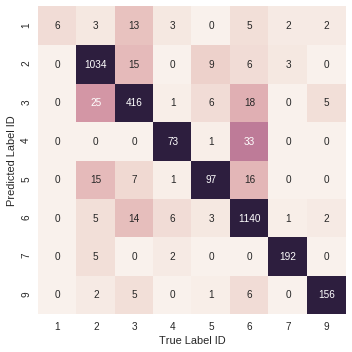

In [28]:
classLabels = ['1', '2', '3', '4', '5', '6', '7', '9']

print confuseMatrix.shape
normConfuseMatrix = np.zeros(confuseMatrix.shape)
for col in np.arange(confuseMatrix.shape[1]):
    normConfuseMatrix[:,col] = confuseMatrix[:,col] / float(confuseMatrix[:,col].max())
    
#dfCM = pd.DataFrame(normConfuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])
dfCM = pd.DataFrame(confuseMatrix, index = [i for i in classLabels], columns = [i for i in classLabels])

fig = plt.figure(figsize=(5,5)) # (width, height)
sns.heatmap(dfCM, annot=True, vmin=0, vmax=70, fmt='d', cbar=False)
#sns.heatmap(dfCM, annot=True, cbar=False)
plt.xlabel('True Label ID')
plt.ylabel('Predicted Label ID')

plt.tight_layout()
plt.savefig('confusion_matrix.pdf')

**Feature Importance**

In [29]:
fitModel = clf.best_estimator_.fit(preProcFeats, preProcLabels)

1 longestRun2 0.0201079339617
2 longestRun0 0.0880155462139
3 bestSNR 0.0460798519478
4 MJDstart 0.0490398075079
5 MJDstart 0.0288295969717
6 globDedisptsStatsMean 0.0356561857266
7 pixelMax_4_3 0.0251321493887
8 globDedisptsStatsRatio1 0.0485563614752


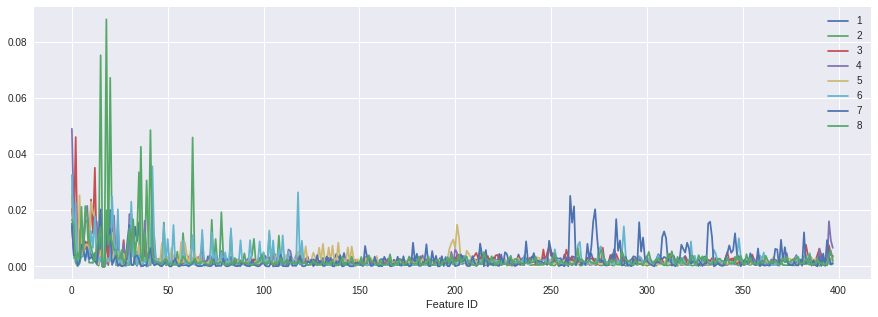

In [30]:
featureStrs = featureDf.columns.values

fig = plt.figure(figsize=(15,5)) # (width, height)
for idx in np.arange(len(fitModel.estimators_)):
    maxFeatVal = fitModel.estimators_[idx].feature_importances_.max()
    plt.plot(fitModel.estimators_[idx].feature_importances_, label=idx+1)
    #plt.plot(fitModel.estimators_[idx].feature_importances_.clip(1e-2, maxFeatVal), label=idx+1)
    #plt.semilogy(fitModel.estimators_[idx].feature_importances_.clip(1e-3, maxFeatVal), label=idx+1)
    print idx+1, featureStrs[np.argmax(fitModel.estimators_[idx].feature_importances_)], maxFeatVal

plt.legend()
plt.xlabel('Feature ID')

In [31]:
print fitModel.predict_proba(preProcFeats)[:10]

[[ 0.03571429  0.          0.          0.          0.01190476  0.
   0.95238095  0.        ]
 [ 0.          0.          0.          0.          0.02439024  0.
   0.97560976  0.        ]
 [ 0.          0.          0.          0.01234568  0.          0.
   0.98765432  0.        ]
 [ 0.04444444  0.02222222  0.03333333  0.01111111  0.73333333  0.06666667
   0.01111111  0.07777778]
 [ 0.01204819  0.          0.          0.01204819  0.01204819  0.
   0.96385542  0.        ]
 [ 0.03571429  0.          0.          0.          0.          0.01190476
   0.95238095  0.        ]
 [ 0.01234568  0.          0.          0.          0.          0.
   0.98765432  0.        ]
 [ 0.02439024  0.          0.          0.          0.          0.
   0.97560976  0.        ]
 [ 0.56122449  0.          0.04081633  0.01020408  0.18367347  0.14285714
   0.          0.06122449]
 [ 0.01234568  0.          0.          0.01234568  0.          0.
   0.97530864  0.        ]]


In [32]:
predictProb = fitModel.predict_proba(preProcFeats)

(13419,)
(13419, 8)
(691, 1)
0.0


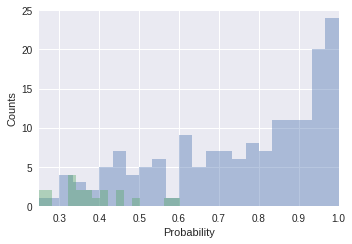

In [48]:
print preProcLabels.shape
print predictProb.shape
print np.argwhere(preProcLabels == 9).shape

#c9c9Prob = predictProb[np.argwhere(preProcLabels == 9).flatten()][:,7]
#cAllc9Prob = predictProb[np.argwhere(preProcLabels != 9).flatten()][:,7]
c9c9Prob = predictTestX[np.argwhere(y_test == 9).flatten()][:,7]
cAllc9Prob = predictTestX[np.argwhere(y_test != 9).flatten()][:,7]
print c9c9Prob.min()

#fig = plt.figure(figsize=(5,4)) # (width, height)
fig, ax = plt.subplots(figsize=(5,3.5)) # (width, height)
for ss in [c9c9Prob, cAllc9Prob]:
    sns.distplot(ss, kde=False, bins=30)
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.xlim(0.25, 1.)
plt.ylim(0, 25)

plt.tight_layout()
plt.savefig('class9_hist.pdf')